In [1]:
import pickle
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation.metrics import *
from neuralhydrology.nh_run import start_run, eval_run, finetune
from neuralhydrology.utils.nh_results_ensemble import create_results_ensemble

In [69]:
config_path = "../initial_exploration/1_basin.yml"
start_run(config_file=Path(config_path), gpu=-1)

2024-02-24 19:46:35,031: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2402_194635/output.log initialized.
2024-02-24 19:46:35,033: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2402_194635
2024-02-24 19:46:35,033: ### Run configurations for ensemble_run_365
2024-02-24 19:46:35,036: experiment_name: ensemble_run_365
2024-02-24 19:46:35,037: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-24 19:46:35,037: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-24 19:46:35,038: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-24 19:46:35,039: train_start_date: 1982-10-01 00:00:00
2024-02-24 19:46:35,039: train_end_date: 1997-09-30 00:00:00
2024-02-24 19:46:35,040: validation_start_date: 1997-10-01 00:00:00
2024-02-24 19:46:35,040: validation_end_date: 2000-09-30 00:00:00
2024-02-24 19:46:35,041: test_start_d

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fdac2aa84c0>
Traceback (most recent call last):
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/site-packages/torch/utils/data/dataloader.py", line 1442, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/multiprocessing/process.py", line 149, in join
    res = self._popen.wait(timeout)
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/multiprocessing/popen_fork.py", line 40, in wait
    if not wait([self.sentinel], timeout):
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/multiprocessing/connection.py", line 931, in wait
    ready = selector.select(timeout)
  File "/Users/evanrobert/anaconda3/envs/lstm/lib/python3.10/selectors.py", lin

# Epoch 2:  55%|█████▍    | 12/22 [00:35<00:29,  3.00s/it, Loss: 0.0620]


KeyboardInterrupt: 

In [19]:
# change directory to directory specified by output of above cell

run_dir = Path("/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335")
eval_run(run_dir=run_dir, period="test")

2024-02-22 03:15:42,239: Using the model weights from /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335/model_epoch032.pt
# Evaluation: 100%|██████████| 1/1 [00:01<00:00,  1.23s/it]
2024-02-22 03:15:43,494: Stored metrics at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335/test/model_epoch032/test_metrics.csv
2024-02-22 03:15:43,495: Stored results at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335/test/model_epoch032/test_results.p


Load and inspect model predictions

In [20]:
with open(run_dir / "test" / "model_epoch032" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results['Tuler']['1D']['xr']

<xarray.Dataset>
Dimensions:                           (date: 1826, time_step: 1)
Coordinates:
  * date                              (date) datetime64[ns] 2000-10-01 ... 20...
  * time_step                         (time_step) int64 0
Data variables:
    ReservoirInflowFLOW-OBSERVED_obs  (date, time_step) float32 6.8 7.9 ... 20.1
    ReservoirInflowFLOW-OBSERVED_sim  (date, time_step) float32 12.2 ... 19.02

In [21]:
#get output from physical model to plot with LSTM output

df = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/HMS_inflow_results_data.csv')

physical_data = df[['Date', 'ReservoirInflowFLOW']]
physical_data["Date"] = pd.to_datetime(physical_data["Date"])


# test_start_date: "01/10/2000"
# test_end_date: "30/09/2005"

start_date = '2000-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
physical_data = physical_data[(physical_data['Date'] >= start_date) & (physical_data['Date'] <= end_date)]

/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_89021/2986311312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_data["Date"] = pd.to_datetime(physical_data["Date"])


Text(0.5, 1.0, 'Test period - NSE 0.662')

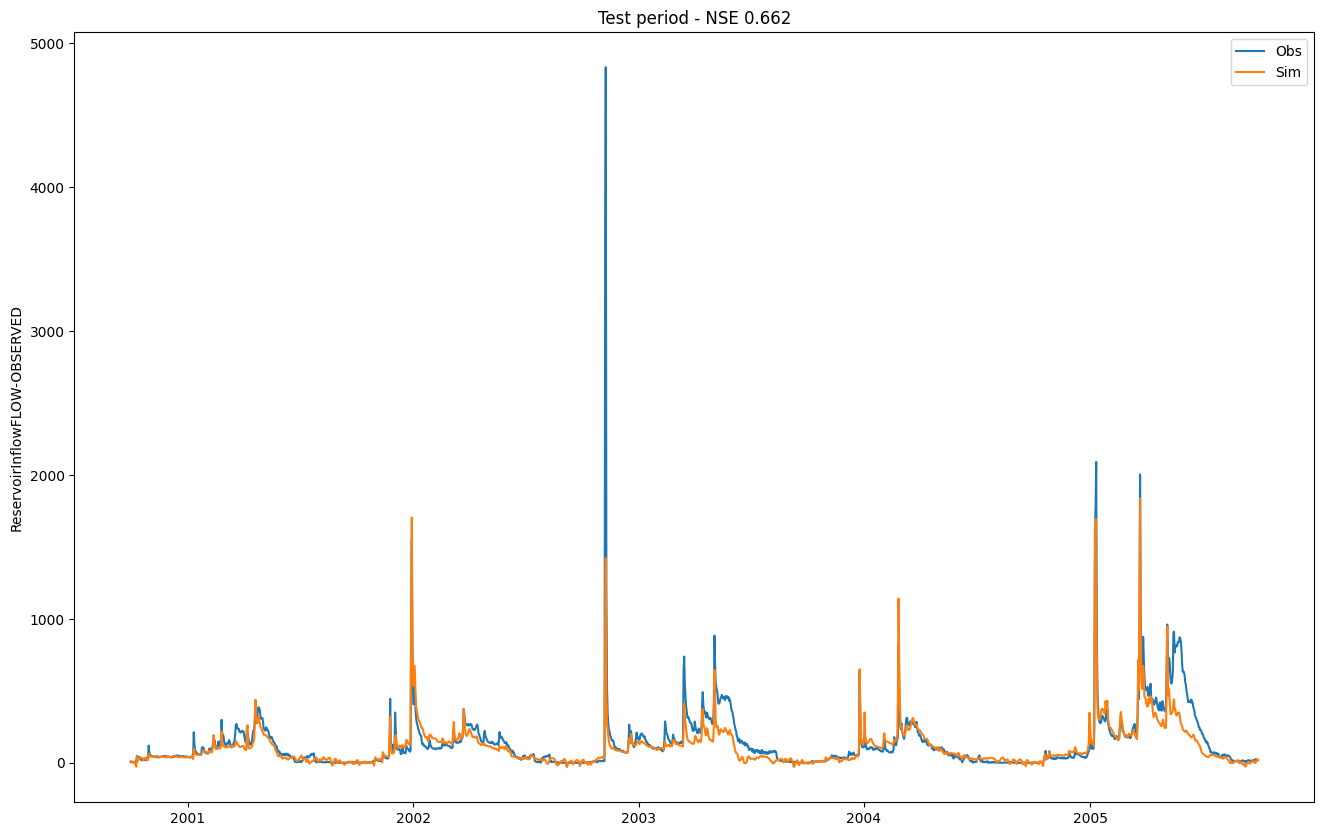

In [27]:
# # extract observations and LSTM simulations
# qobs = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
# qsim = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

# fig, ax = plt.subplots(figsize=(16,10))
# ax.plot(physical_data["Date"], qobs, label = "observed")
# ax.plot(physical_data["Date"], physical_data['ReservoirInflowFLOW'], label= "physical model")
# ax.plot(physical_data["Date"], qsim, label = "LSTM")
# ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
# ax.set_title(f"Test period - NSE {results['Tuler']['1D']['NSE']:.3f}")
# ax.legend()
# plt.show()

# extract observations and LSTM simulations
qobs = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = results['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["date"], qobs, label="Obs")
ax.plot(qsim["date"], qsim, label="Sim")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.legend()
ax.set_title(f"Test period - NSE {results['Tuler']['1D']['NSE']:.3f}")

## Ensemble Run

In [3]:
start_run(config_file=Path("../initial_exploration/1_basin.yml"), gpu=-1)

2024-02-22 19:40:15,663: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_194015/output.log initialized.
2024-02-22 19:40:15,664: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_194015
2024-02-22 19:40:15,665: ### Run configurations for ensemble_run_365
2024-02-22 19:40:15,666: experiment_name: ensemble_run_365
2024-02-22 19:40:15,667: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 19:40:15,668: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 19:40:15,669: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 19:40:15,673: train_start_date: 1982-10-01 00:00:00
2024-02-22 19:40:15,675: train_end_date: 1997-09-30 00:00:00
2024-02-22 19:40:15,677: validation_start_date: 1997-10-01 00:00:00
2024-02-22 19:40:15,678: validation_end_date: 2000-09-30 00:00:00
2024-02-22 19:40:15,679: test_start_d

In [14]:
import warnings

#warnings.filterwarnings("ignore", message="Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.")

num_ensemble_members = 8
config_path = "../initial_exploration/1_basin.yml"
for i in range(num_ensemble_members):
    start_run(config_file=Path(config_path), gpu=-1)


2024-02-22 02:11:27,746: Logging to /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run2_2202_021127/output.log initialized.
2024-02-22 02:11:27,749: ### Folder structure created at /Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run2_2202_021127
2024-02-22 02:11:27,749: ### Run configurations for ensemble_run2
2024-02-22 02:11:27,750: experiment_name: ensemble_run2
2024-02-22 02:11:27,750: train_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 02:11:27,750: validation_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 02:11:27,751: test_basin_file: ../initial_exploration/exploration_tuler
2024-02-22 02:11:27,751: train_start_date: 1982-10-01 00:00:00
2024-02-22 02:11:27,752: train_end_date: 1997-09-30 00:00:00
2024-02-22 02:11:27,752: validation_start_date: 1997-10-01 00:00:00
2024-02-22 02:11:27,753: validation_end_date: 2000-09-30 00:00:00
2024-02-22 02:11:27,753: test_start_date: 2000-10

In [2]:
#collect run directories
#TODO automate this

ensemble_runs = [Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_024335'), 
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_120528'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_121917'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_123346'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_124719'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_134044'),
Path('/Users/evanrobert/Documents/ESDL_Research/ESDL_LSTM/neuralhydrology/runs/ensemble_run_365_2202_194015')
]
for run in ensemble_runs:
    eval_run(run_dir=run, period="test")
    eval_run(run_dir=run, period="validation")

# Validation: 100%|██████████| 1/1 [00:00<00:00,  1.45it/s]


In [3]:
ensemble_run = create_results_ensemble(ensemble_runs, period='test')

Loading results for each run.


100%|██████████| 7/7 [00:00<00:00, 1247.35it/s]


Combining results and calculating metrics.


100%|██████████| 1/1 [00:00<00:00, 95.61it/s]


Text(0.5, 1.0, 'Test period - NSE 0.655')

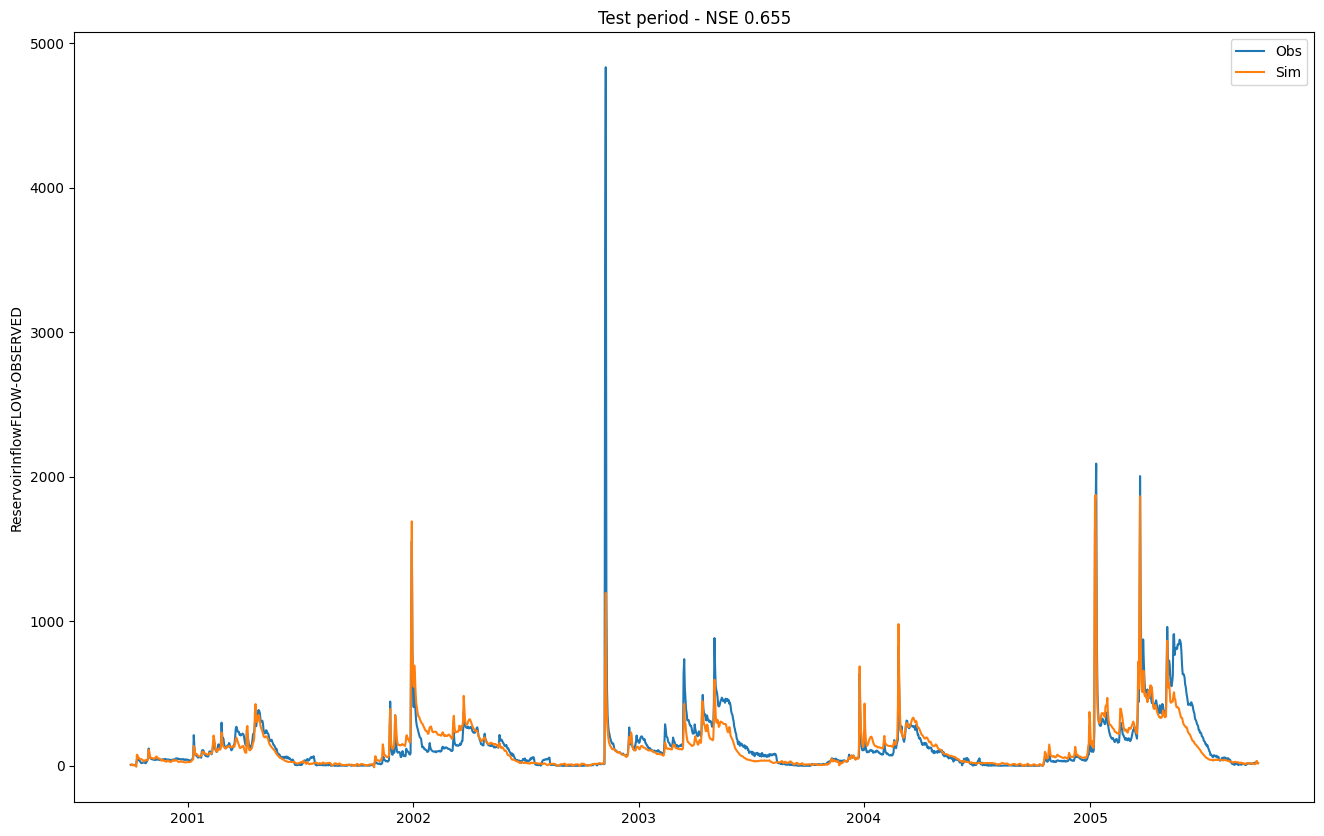

In [4]:
# extract observations and LSTM simulations
qobs = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs["datetime"], qobs, label="Obs")
ax.plot(qsim["datetime"], qsim, label="Sim")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.legend()
ax.set_title(f"Test period - NSE {ensemble_run['Tuler']['1D']['NSE']:.3f}")

In [14]:
#see all model errors
for run in ensemble_runs:
    with open(run / "test" / "model_epoch032" / "test_results.p", "rb") as fp:
        results = pickle.load(fp)
        print(f"{results['Tuler']['1D']['NSE']:.3f}")

0.662
0.661
0.574
0.682
0.596
0.552
0.667


In [6]:
#get output from physical model to plot with LSTM output

df = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/HMS_inflow_results_data.csv')

physical_data = df[['Date', 'ReservoirInflowFLOW']]
physical_data["Date"] = pd.to_datetime(physical_data["Date"])


# test_start_date: "01/10/2000"
# test_end_date: "30/09/2005"

start_date = '2000-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
physical_data = physical_data[(physical_data['Date'] >= start_date) & (physical_data['Date'] <= end_date)]

/var/folders/93/12rdf89j3ql6h5j8b_3g9ddm0000gn/T/ipykernel_8956/2986311312.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  physical_data["Date"] = pd.to_datetime(physical_data["Date"])


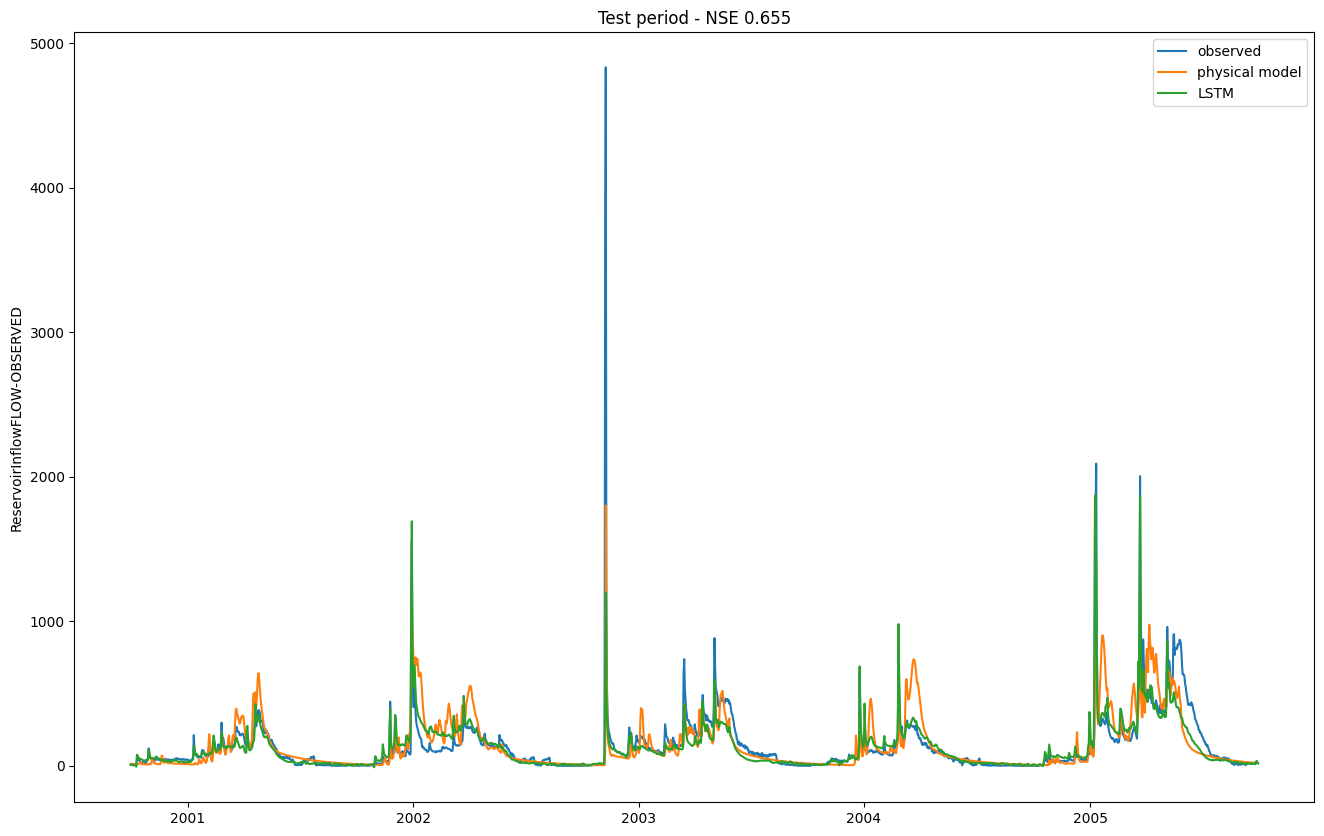

In [8]:
# extract observations and LSTM simulations
qobs = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(physical_data["Date"], qobs, label = "observed")
ax.plot(physical_data["Date"], physical_data['ReservoirInflowFLOW'], label= "physical model")
ax.plot(physical_data["Date"], qsim, label = "LSTM")
ax.set_ylabel("ReservoirInflowFLOW-OBSERVED")
ax.set_title(f"Test period - NSE {ensemble_run['Tuler']['1D']['NSE']:.3f}")
ax.legend()
plt.show()

### Matlab vs NeuralHydrology predictions

In [30]:
#get matlab lstm predictions from Dino's csv

matlab_lstm = pd.read_csv('/Users/evanrobert/Documents/ESDL_Research/Training_Data_3_Basins/Dino_MatlabLSTM_testresults.csv')
matlab_lstm["Date"] = pd.to_datetime(matlab_lstm["DateTime"])
matlab_lstm = matlab_lstm[['Date', 'LSTM-HMS']]

start_date = '2000-10-01'
end_date = '2005-09-30'

# Filter the DataFrame to keep only the dates within the specified range
matlab_lstm = matlab_lstm[(matlab_lstm['Date'] >= start_date) & (matlab_lstm['Date'] <= end_date)]

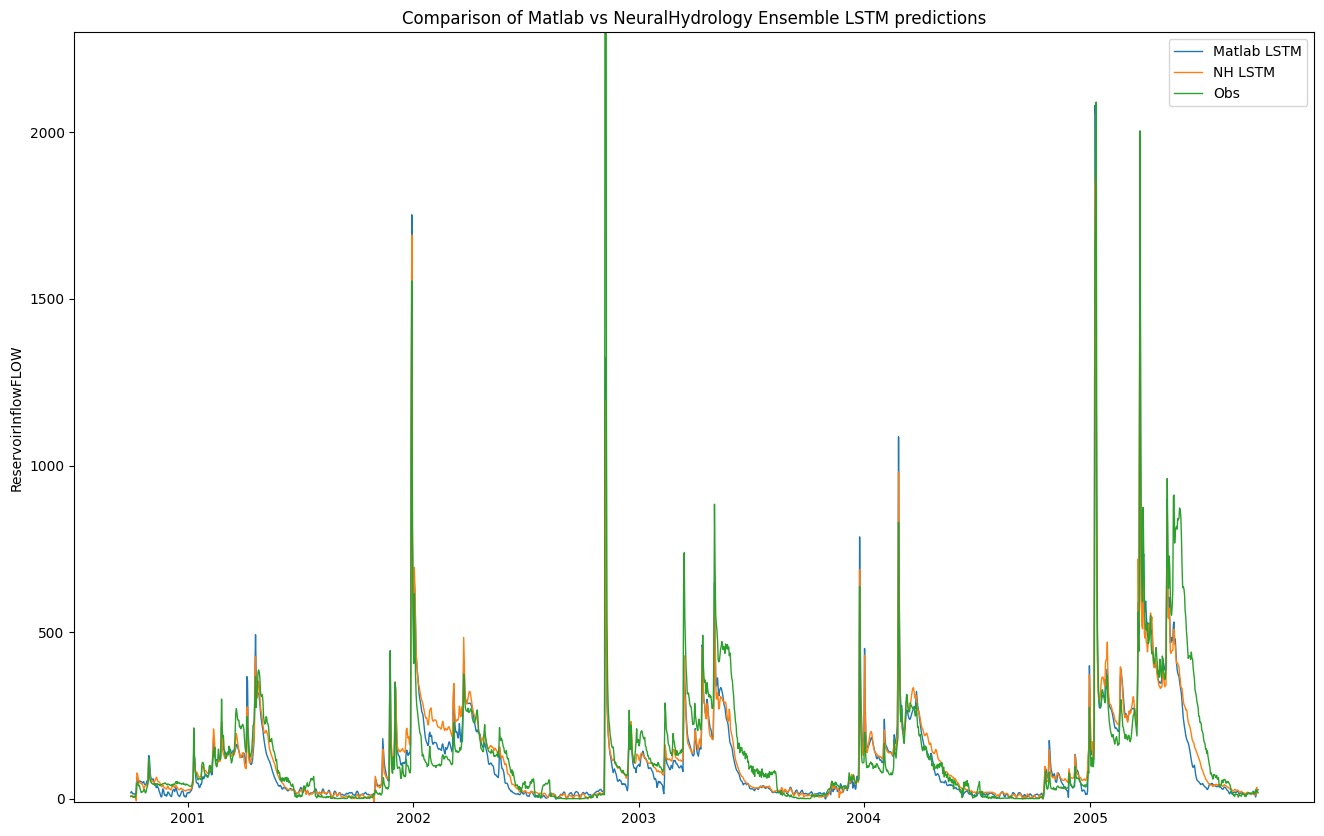

In [67]:
# ensemble run predictions
qobs = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_obs']
qsim = ensemble_run['Tuler']['1D']['xr']['ReservoirInflowFLOW-OBSERVED_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(matlab_lstm['Date'], matlab_lstm["LSTM-HMS"], label="Matlab LSTM", alpha=1, color='#1f77b4', lw=1)
ax.plot(qsim["datetime"], qsim, label="NH LSTM", alpha=1, color='#ff7f0e', lw=1)
ax.plot(qobs["datetime"], qobs, label="Obs", alpha=1, color='#2ca02c', lw=1)

ax.set_ylim((-10, 2300))

ax.set_ylabel("ReservoirInflowFLOW")
ax.set_title(f"Comparison of Matlab vs NeuralHydrology Ensemble LSTM predictions")
ax.legend()